Clustering, Análisis de Correspondencias y Algoritmo de Boosting para predicción del re-enrolamiento de estudiantes desertores
===

#### Importación librerías de trabajo

In [773]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

#### Importación dataset de trabajo clustering

In [774]:
# Importación dataset de trabajo

dfc = pd.read_csv('casestudy_dropout_clean.csv')
dfc.head()

,DayOfWeekDroppedOut,PrioritaryStudentIn2021,Female,Age,GraduatedIn2021,Migrant,ListedInDropoutReport,SchoolPrincipalADP,EnrolledByAug312022,MunicipalSchool,DroppedOutMay30Before,niv_rend,nivel_enseñanza,nivel_enseñanza2,periodo_abandono,anticipacion_abandono,asistencia_2021
0,5,0,0,18,0,0,0,1,0,1,0,Menor 4.0,Secundaria,4. 3ro-4to medio,Después_31_mayo,75,Menos del 85%
1,5,0,1,15,0,0,1,1,1,1,1,Menor 4.0,Secundaria,3. 1ro-2do medio,Antes_31_mayo,110,Menos del 85%
2,3,1,1,14,1,0,0,1,0,1,1,4.0 - 4.9,Secundaria,3. 1ro-2do medio,Antes_31_mayo,133,85% y más
3,1,1,1,14,1,0,1,1,0,1,1,5.0 - 5.9,Secundaria,3. 1ro-2do medio,Antes_31_mayo,121,85% y más
4,3,0,1,17,1,0,0,1,0,1,0,4.0 - 4.9,Secundaria,4. 3ro-4to medio,Después_31_mayo,77,85% y más


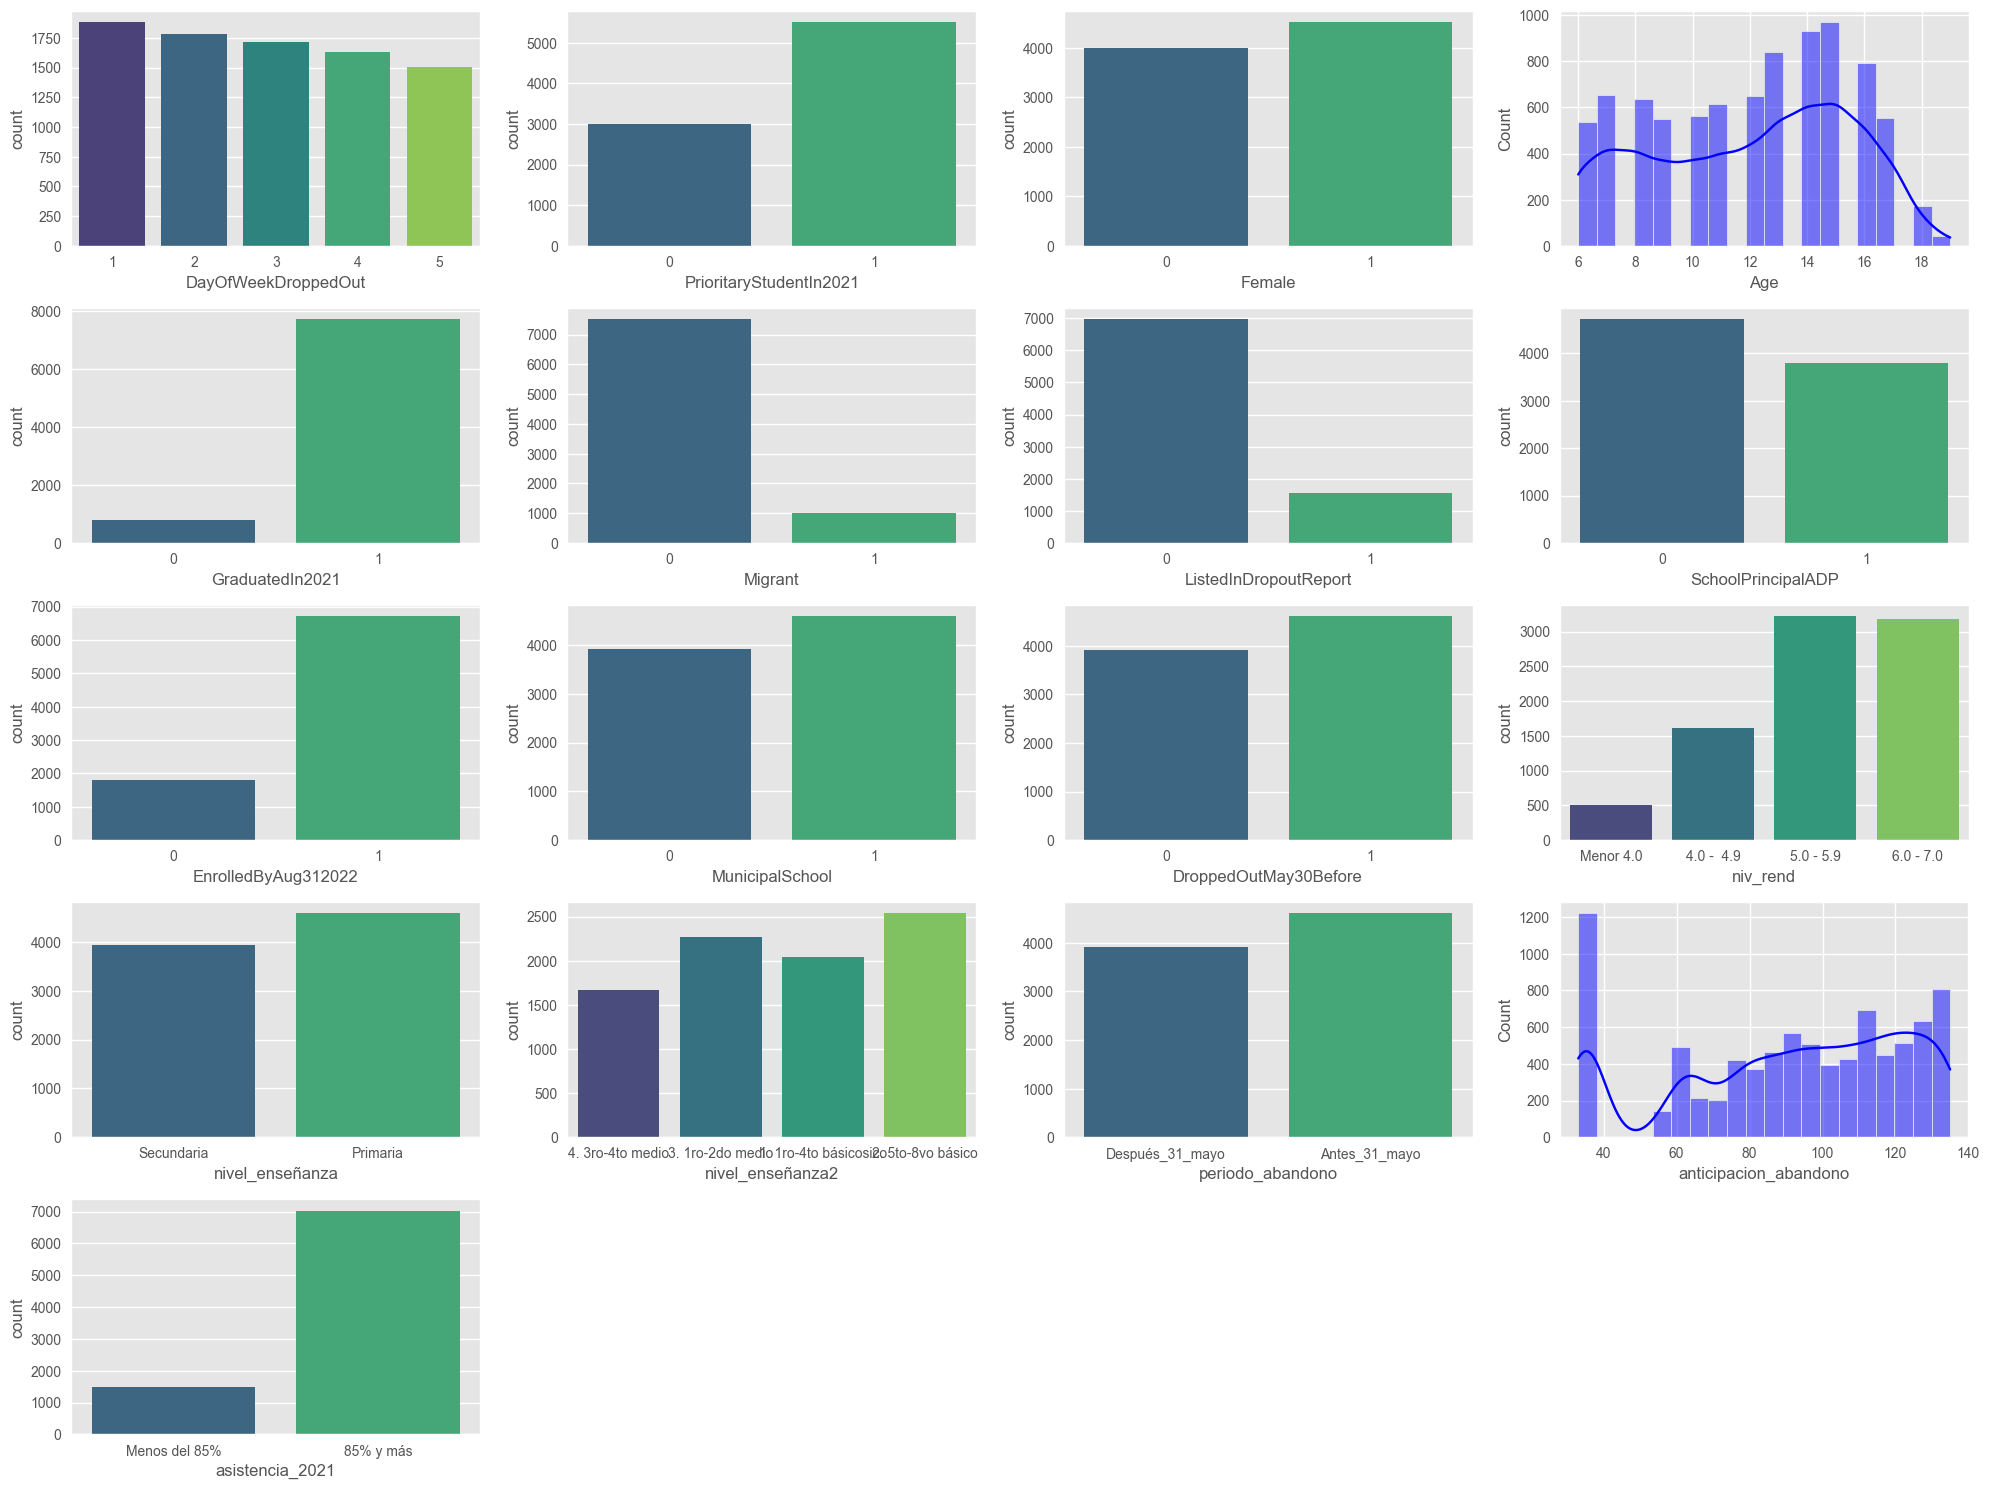

In [775]:
# Graficación de las variables dataset

plt.style.use('ggplot')

nrows=5
ncols=4

plt.figure(figsize=(20,15))

for cols in dfc.columns:
    if dfc[cols].nunique() < 13:
        plt.subplot(nrows, ncols, dfc.columns.get_loc(cols)+1)
        sns.countplot(data=dfc, x=cols, palette='viridis');
        #plt.title(cols)
    
    else:
        plt.subplot(nrows, ncols, dfc.columns.get_loc(cols)+1)
        sns.histplot(dfc[cols], kde=True, color='blue', bins=20);
        #plt.title(cols)

plt.tight_layout();

In [776]:
# Con pd.get_dummies() se convierten las variables nivel_enseñanza2 y niv_rend en variables dummies

dfc = pd.get_dummies(dfc, columns=['nivel_enseñanza2', 'niv_rend','DayOfWeekDroppedOut'], dtype=int)
dfc.drop(columns=['nivel_enseñanza'], inplace=True)
dfc.head()

,PrioritaryStudentIn2021,Female,Age,GraduatedIn2021,Migrant,ListedInDropoutReport,SchoolPrincipalADP,EnrolledByAug312022,MunicipalSchool,DroppedOutMay30Before,periodo_abandono,anticipacion_abandono,asistencia_2021,nivel_enseñanza2_1. 1ro-4to básicosico,nivel_enseñanza2_2. 5to-8vo básico,nivel_enseñanza2_3. 1ro-2do medio,nivel_enseñanza2_4. 3ro-4to medio,niv_rend_4.0 - 4.9,niv_rend_5.0 - 5.9,niv_rend_6.0 - 7.0,niv_rend_Menor 4.0,DayOfWeekDroppedOut_1,DayOfWeekDroppedOut_2,DayOfWeekDroppedOut_3,DayOfWeekDroppedOut_4,DayOfWeekDroppedOut_5
0,0,0,18,0,0,0,1,0,1,0,Después_31_mayo,75,Menos del 85%,0,0,0,1,0,0,0,1,0,0,0,0,1
1,0,1,15,0,0,1,1,1,1,1,Antes_31_mayo,110,Menos del 85%,0,0,1,0,0,0,0,1,0,0,0,0,1
2,1,1,14,1,0,0,1,0,1,1,Antes_31_mayo,133,85% y más,0,0,1,0,1,0,0,0,0,0,1,0,0
3,1,1,14,1,0,1,1,0,1,1,Antes_31_mayo,121,85% y más,0,0,1,0,0,1,0,0,1,0,0,0,0
4,0,1,17,1,0,0,1,0,1,0,Después_31_mayo,77,85% y más,0,0,0,1,1,0,0,0,0,0,1,0,0


In [777]:
# Separar vector objetivo del dataset

y = dfc['EnrolledByAug312022']
dfc.drop(columns=['EnrolledByAug312022', 'DroppedOutMay30Before'],inplace=True)

In [778]:
# Label encoder para las variables nivel_enseñanza, periodo_abandono, asistencia_2021

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

#dfc['nivel_enseñanza'] = le.fit_transform(dfc['nivel_enseñanza'])
dfc['periodo_abandono'] = le.fit_transform(dfc['periodo_abandono'])
dfc['asistencia_2021'] = le.fit_transform(dfc['asistencia_2021'])


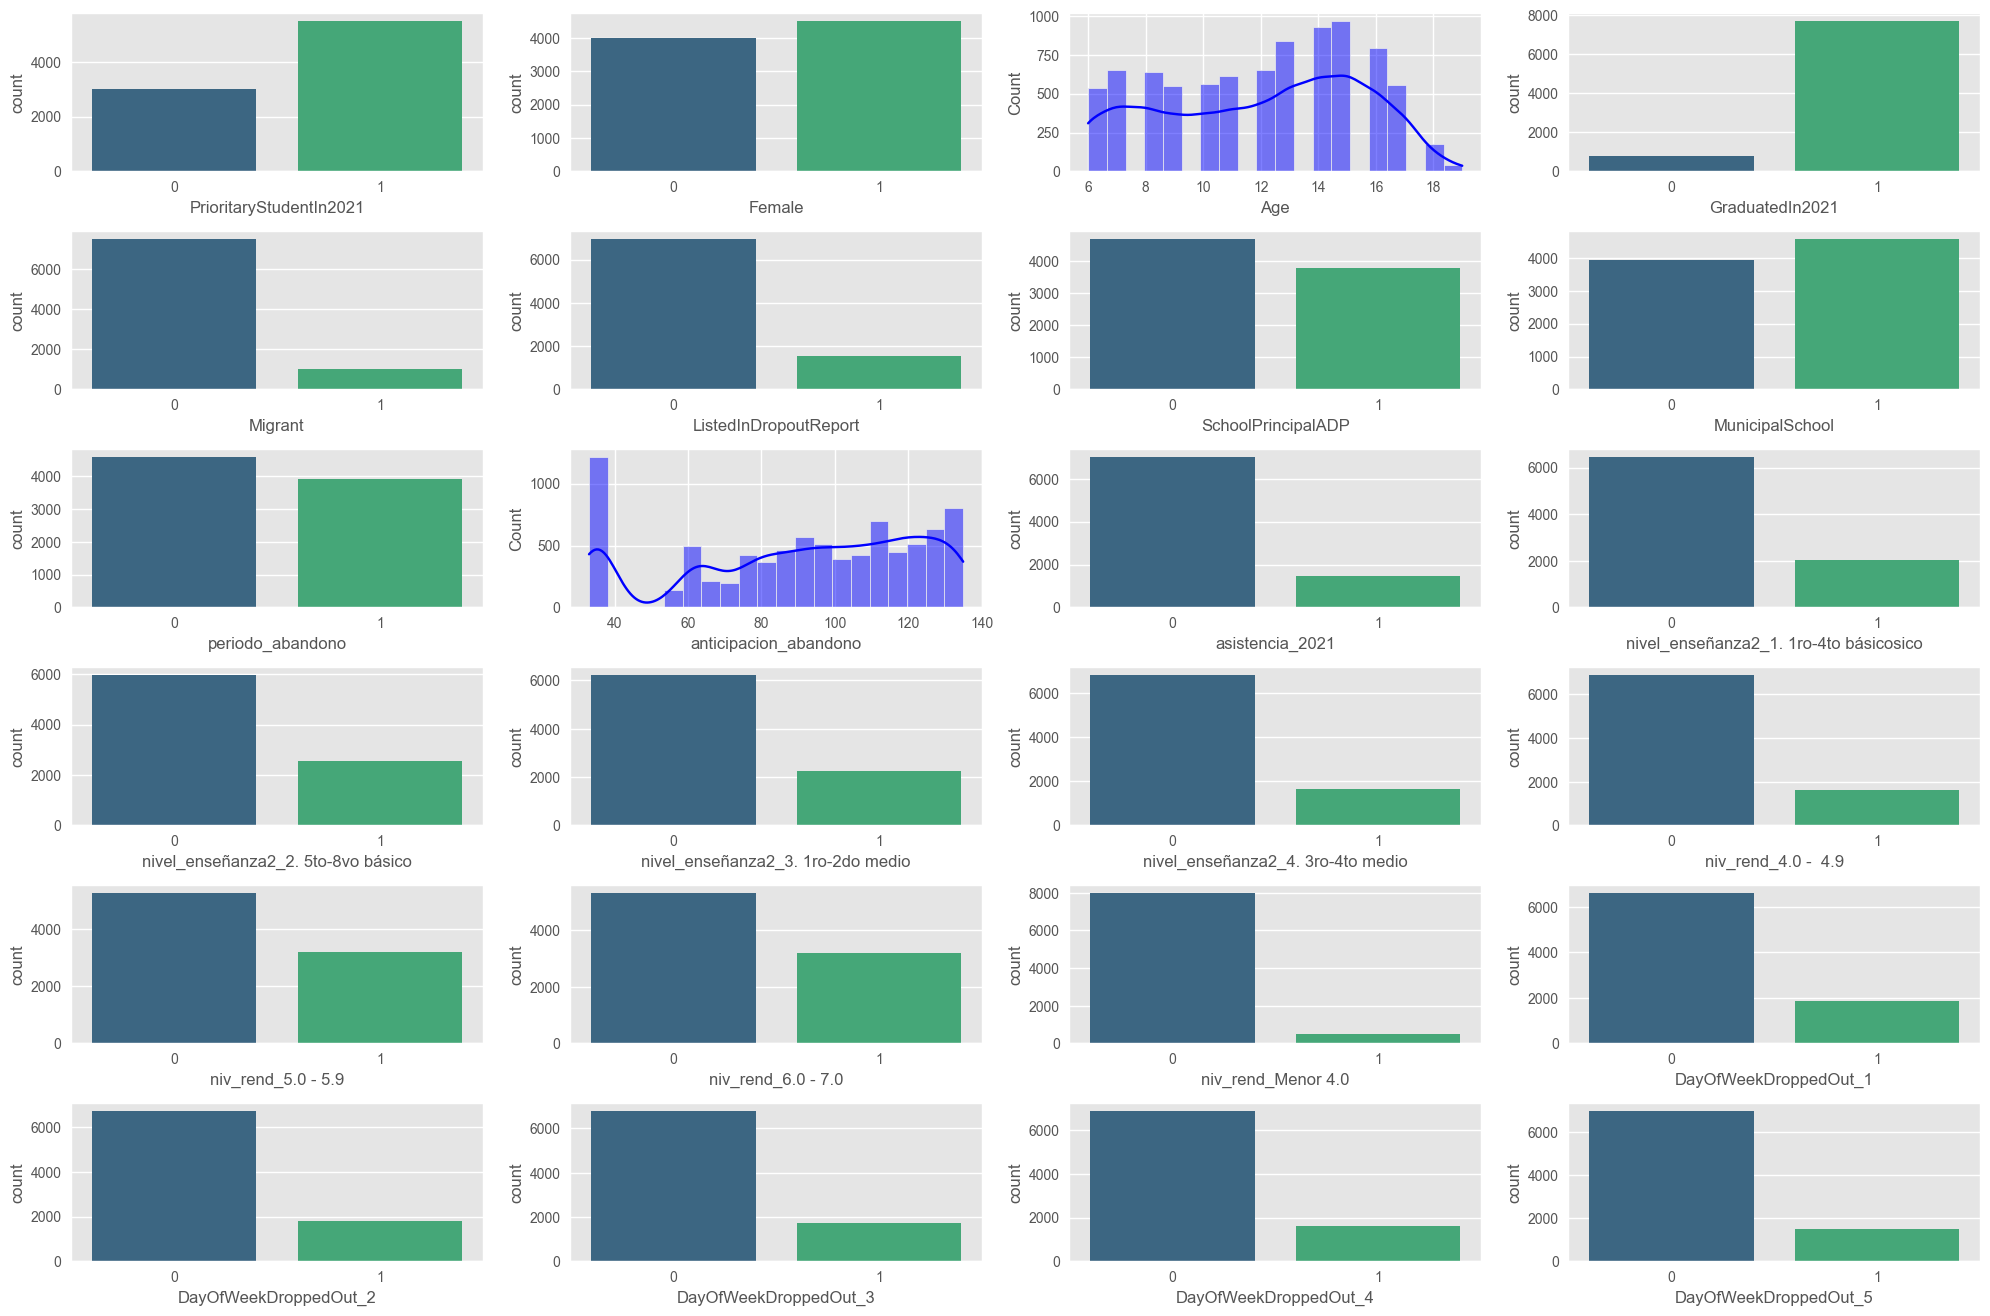

In [779]:
# Graficación de las variables dataset

plt.style.use('ggplot')

nrows=7
ncols=4

plt.figure(figsize=(20,15))

for cols in dfc.columns:
    if dfc[cols].nunique() < 13:
        plt.subplot(nrows, ncols, dfc.columns.get_loc(cols)+1)
        sns.countplot(data=dfc, x=cols, palette='viridis');
        #plt.title(cols)
    
    else:
        plt.subplot(nrows, ncols, dfc.columns.get_loc(cols)+1)
        sns.histplot(dfc[cols], kde=True, color='blue', bins=20);
        #plt.title(cols)

plt.tight_layout();

In [780]:
# Escalamiento de las variables con MinMaxScaler

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(dfc), columns=dfc.columns)
df_scaled.head()

,PrioritaryStudentIn2021,Female,Age,GraduatedIn2021,Migrant,ListedInDropoutReport,SchoolPrincipalADP,MunicipalSchool,periodo_abandono,anticipacion_abandono,asistencia_2021,nivel_enseñanza2_1. 1ro-4to básicosico,nivel_enseñanza2_2. 5to-8vo básico,nivel_enseñanza2_3. 1ro-2do medio,nivel_enseñanza2_4. 3ro-4to medio,niv_rend_4.0 - 4.9,niv_rend_5.0 - 5.9,niv_rend_6.0 - 7.0,niv_rend_Menor 4.0,DayOfWeekDroppedOut_1,DayOfWeekDroppedOut_2,DayOfWeekDroppedOut_3,DayOfWeekDroppedOut_4,DayOfWeekDroppedOut_5
0,0.0,0.0,0.923077,0.0,0.0,0.0,1.0,1.0,1.0,0.411765,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.692308,0.0,0.0,1.0,1.0,1.0,0.0,0.754902,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.0,1.0,0.615385,1.0,0.0,0.0,1.0,1.0,0.0,0.980392,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,1.0,0.615385,1.0,0.0,1.0,1.0,1.0,0.0,0.862745,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.846154,1.0,0.0,0.0,1.0,1.0,1.0,0.431373,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


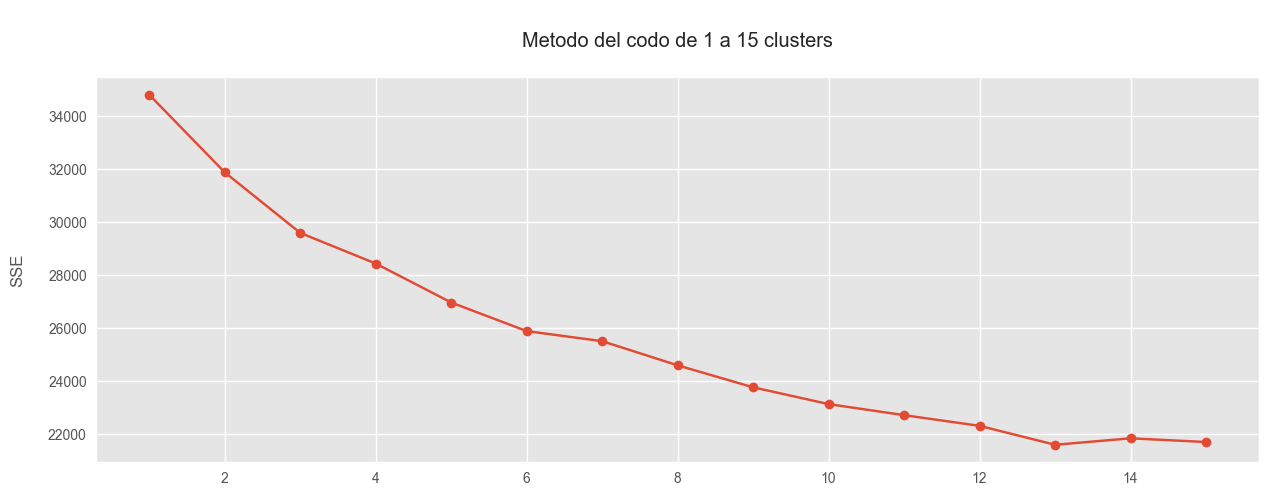

In [781]:
# Método del codo con inertia

plt.figure(figsize=(15, 5))

sse = []

clusters = list(range(1, 16))
for k in clusters:
    kmeans = KMeans(n_clusters=k,random_state=20).fit(df_scaled)
    sse.append(kmeans.inertia_)

plt.plot(clusters, sse, marker="o")
plt.title("\nMetodo del codo de 1 a 15 clusters\n")
plt.ylabel("SSE\n")
plt.show()

### Determinación de número de clúster con método jerarquico aglomerativo

In [782]:
# Clustering con Kmeans con 6 clusters 

kmeans = KMeans(n_clusters=6, random_state=20).fit(df_scaled)
dfc['cluster_kmeans'] = kmeans.labels_
dfc['cluster_kmeans'].value_counts()

cluster_kmeans
2    2029
4    1645
1    1345
0    1299
3    1198
5    1000
Name: count, dtype: int64

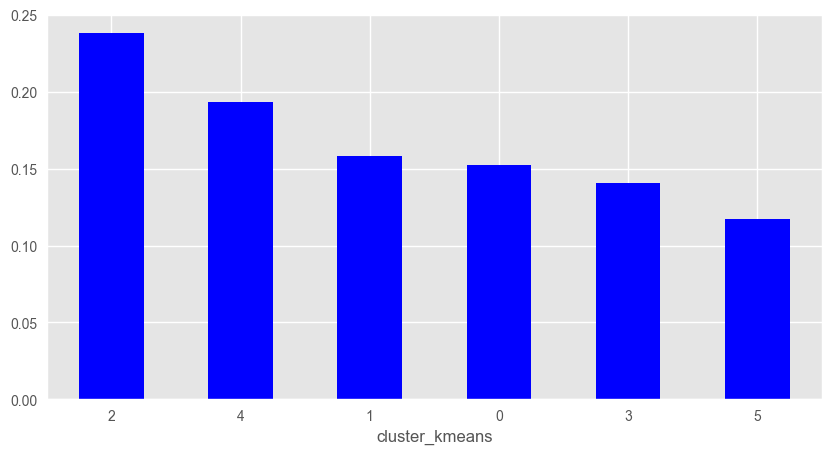

In [783]:
dfc['cluster_kmeans'].value_counts("%").plot(kind='bar', color='blue', figsize=(10, 5))
plt.xticks(rotation=0);

In [784]:
dfc.columns

Index(['PrioritaryStudentIn2021', 'Female', 'Age', 'GraduatedIn2021',
       'Migrant', 'ListedInDropoutReport', 'SchoolPrincipalADP',
       'MunicipalSchool', 'periodo_abandono', 'anticipacion_abandono',
       'asistencia_2021', 'nivel_enseñanza2_1. 1ro-4to básicosico',
       'nivel_enseñanza2_2. 5to-8vo básico',
       'nivel_enseñanza2_3. 1ro-2do medio',
       'nivel_enseñanza2_4. 3ro-4to medio', 'niv_rend_4.0 -  4.9',
       'niv_rend_5.0 - 5.9', 'niv_rend_6.0 - 7.0', 'niv_rend_Menor 4.0',
       'DayOfWeekDroppedOut_1', 'DayOfWeekDroppedOut_2',
       'DayOfWeekDroppedOut_3', 'DayOfWeekDroppedOut_4',
       'DayOfWeekDroppedOut_5', 'cluster_kmeans'],
      dtype='object')

### Reducción de dimensionalidad con PCA a dos componentes para gráficar resultados clutering

In [785]:
# Extracción de componentes principales con PCA

pca = PCA(n_components=2) 
pca_result = pca.fit_transform(df_scaled) 


In [786]:
# Se crea un DataFrame con los resultados de PCA
pca_result = pd.DataFrame(pca_result, columns=[f'PC_{i+1}' for i in range(pca_result.shape[1])])
pca_result.head()

,PC_1,PC_2
0,-0.641483,0.355796
1,-0.939997,0.205477
2,-0.991206,0.255522
3,-1.244067,0.008919
4,-0.645375,0.406924


In [787]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=df_scaled.columns)
loadings.sort_values(by='PC2', ascending=False)

,PC1,PC2
SchoolPrincipalADP,-0.394089,0.576130
MunicipalSchool,-0.420178,0.560629
niv_rend_6.0 - 7.0,0.493140,0.358399
nivel_enseñanza2_1. 1ro-4to básicosico,0.313228,0.207193
Migrant,0.032554,0.096111
periodo_abandono,0.119024,0.060802
nivel_enseñanza2_2. 5to-8vo básico,0.055224,0.045299
GraduatedIn2021,0.085289,0.034353
DayOfWeekDroppedOut_1,-0.001913,0.013268
DayOfWeekDroppedOut_4,-0.008968,0.011561


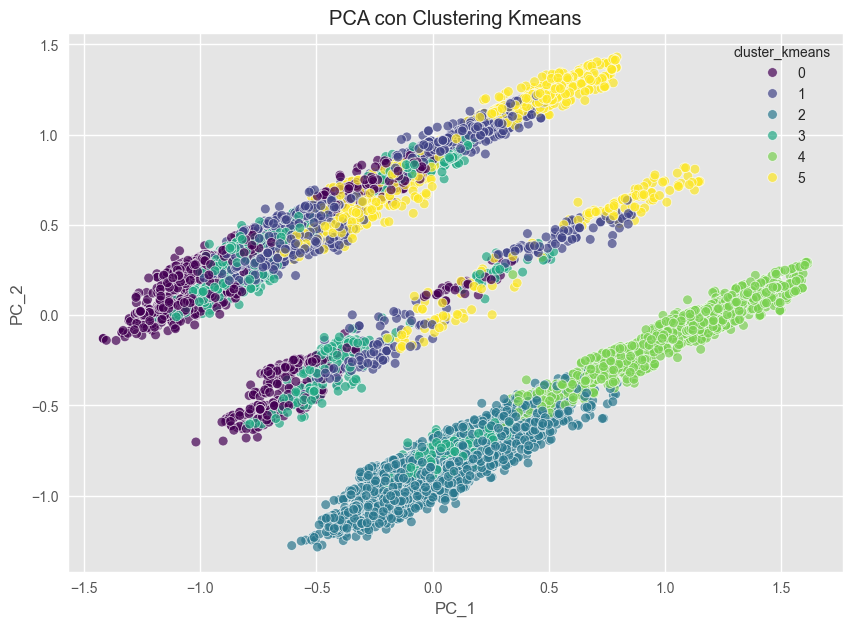

In [788]:
# Graficación de los componentes principales con los resultados del kmeans

plt.figure(figsize=(10, 7))

sns.scatterplot(data=pca_result, x='PC_1', y='PC_2', hue=dfc['cluster_kmeans'], palette='viridis', alpha=0.7)
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.title('PCA con Clustering Kmeans')
plt.show()

In [789]:
# Pegamos el vector objetivo al dataset de trabajo

dfc['EnrolledByAug312022'] = y

In [790]:
# Caracterización descriptiva de los clusters mediante el uso de la función groupby() y describe()

tabla_clusters = dfc.groupby('cluster_kmeans').agg(['mean']).T.round(3)
tabla_clusters = pd.DataFrame(tabla_clusters)
tabla_clusters.columns =['I', 'II', 'III', 'IV', 'V','VI']
tabla_clusters

,,I,II,III,IV,V,VI
PrioritaryStudentIn2021,mean,0.717,0.649,0.673,0.745,0.488,0.643
Female,mean,0.566,0.525,0.550,0.552,0.464,0.538
Age,mean,15.329,11.195,12.835,15.193,9.809,7.307
GraduatedIn2021,mean,0.846,0.941,0.887,0.834,0.994,0.927
Migrant,mean,0.084,0.187,0.078,0.103,0.087,0.212
ListedInDropoutReport,mean,0.416,0.125,0.205,0.007,0.164,0.146
SchoolPrincipalADP,mean,0.801,0.870,0.000,0.625,0.000,0.841
MunicipalSchool,mean,1.000,1.000,0.000,0.789,0.001,1.000
periodo_abandono,mean,0.002,0.475,0.384,1.000,0.488,0.490
anticipacion_abandono,mean,115.327,90.458,95.667,65.086,89.568,88.415


### Caracterización de los clusters:   

1. El cluster I se caracteriza por agrupar una proporción importantes de estudiantes prioritarios (71.7%), que tiene una edad promedio de 15.3 años; el 56% son mujeres; el 41.6% de ellos aparece registrado en el reporte de abandono, el 100% asiste a escuelas municipales; abandonan la escuela con 115 días de anticipación -respecto de la fecha de referencia (30 agosto), el 100% son estudiantes secundarios; 11% tienen un rendimiento promedio bajo nota 4.0 y presentan un bajo porcentaje de re-enrolamiento (65.5%)  

2. El cluster II agrupa estudiantes donde el 65% son estudiantes prioritarios, tienen una edad promedio de 11 años; el 18% de ellos son migrantes; el 94% se graduo el año 2021, el 12% aparece en el registro de reporte de abandono escolar; todos estudian en establecimientos educacionales. Con respecto al 30 de agosto, abandonan la escuela con 90 días de anticipación; tienden a presentar rendimiento escolar en los tramos más altos (42% en el tramo 5.0-5.9 y 38% sobre nota 6.0). Presenta un 85.9% de ren-enrolamiento escolar.   

3. Por su parte, el cluster III está compuesto por un 67% de estudiantes prioritarios, 55% de estudiantes mujeres, tienen una edad promedio de 12.8 años; el 20% aparece en el registro, abandonan la escuela con un promedio de 95 días de anticipación; ninguno asiste a establecimientos municipales; en su mayoría pertencen al 2do ciclo de enseñanza básica (5to-8vo básico) y al 1er ciclo de enseñanza media (1ro-2do medio): 33.8% y 30.2% repectivamente. El 72.8% de los estudiantes de este cluster se ubica en el rango de rendimiento del 5.0 a 5.9. Por último, el 80.7% de los estudiantes de este cluster aparece re-enrolado al 30 de agosto del 2022.   

4. El cluster IV se caracteriza por agrupar estudiantes en su gran mayoría prioritarios (74.5%), tener un promedio de edad de 15.2 años; el 78.9% asiste a establecimientos municipales; un cuarto de ellos abandonan la escuela a mitad de semana; abandonando el colegio con 65 días de anticipación; todos cursan estudios secundarios, el 40% tiene un rendimiento académico promedio entre 4.0 y 4.9 (donde solo el 15.9% tiene un rendimiento sobre 6.0) y el 66.2% se encuentra re-enrolado al 30 de agosto.  

5. El cluster V está caracterizado por tener un bajo procentaje de estudiantes prioritarios (48.8%) y un alto porcentaje de estudiantes hombres (54.6%); edad promedio de 9.8 años; el 99% se graduó en 2021, 16.4% aparece en el reporte de abandono escolar; abandonan la escuela con un promedio de 89.5 días de anticipación; en su mayoría son estudiantes del ciclo básico de enseñanza (47% y 30.7%), y en su gran mayoría, tienen buen rendimiento (97.9% tiene rendimiento promedio sobre 6.0). El 85.9% de los estudiantes de este cluster aparece re-enrolado al 30 de agosto.  

6. El cluster VI se caracteriza por estudiantes infantes: la edad promedio de 7.3 años, donde el 64% tiene la condición de estudiante prioritario; el 21.2% presenta la condición de migrante, todos asisten a establecimientos municipales; abandonan el colegio con 88 días de anticipación; todos cursan el 1er ciclo básico de enseñanza (de 1ro a 4to básico). El 85.8% de los estudiantes de este cluster aparece re-enrolado al 30 de agosto.  

El análisis descriptivo del clustering revela que los clusters I y IV son los que presentan los porcentajes más bajos de re-enrolamiento. Lo común a ambos clusters es que están integrados por estudiantes mayoritariamente mujeres, de condición prioritaria, adolescentes (edad promedio en torno a los 15 años); rendimientos académicos más bien bajos y estar cursando estudios medios.



### Análisis de correspondencias

In [791]:
# Importamos dataset con etiquetas categóricas

df_cat = pd.read_csv('dfcat.csv')
df_cat.head()

,curso_2022,día_sem,est_priorit,sexo,graduado_2021,est_migrante,reportado,dir_ADP,reincorp_30ago,graduado_2022,esc_municipal,deserción_antes30may
0,4° med,Viernes,No,Hombre,No,No,No,Sí,No,No,Sí,No
1,1° med,Viernes,No,Mujer,No,No,Sí,Sí,Sí,No,Sí,Sí
2,2° med,Miércoles,Sí,Mujer,Sí,No,No,Sí,No,No,Sí,Sí
3,2° med,Lunes,Sí,Mujer,Sí,No,Sí,Sí,No,No,Sí,Sí
4,4° med,Miércoles,No,Mujer,Sí,No,No,Sí,No,No,Sí,No


In [ ]:
# Análisis de correspondencias de variables categóricas con prince

import prince

In [793]:
# Instanciar el objeto MCA y entrenar

ca = prince.MCA(n_components=2)
ca = ca.fit(df_cat)

In [ ]:
# Coordenadas de las filas y columnas

row_coords = ca.row_coordinates(df_cat)
col_coords = ca.column_coordinates(df_cat)

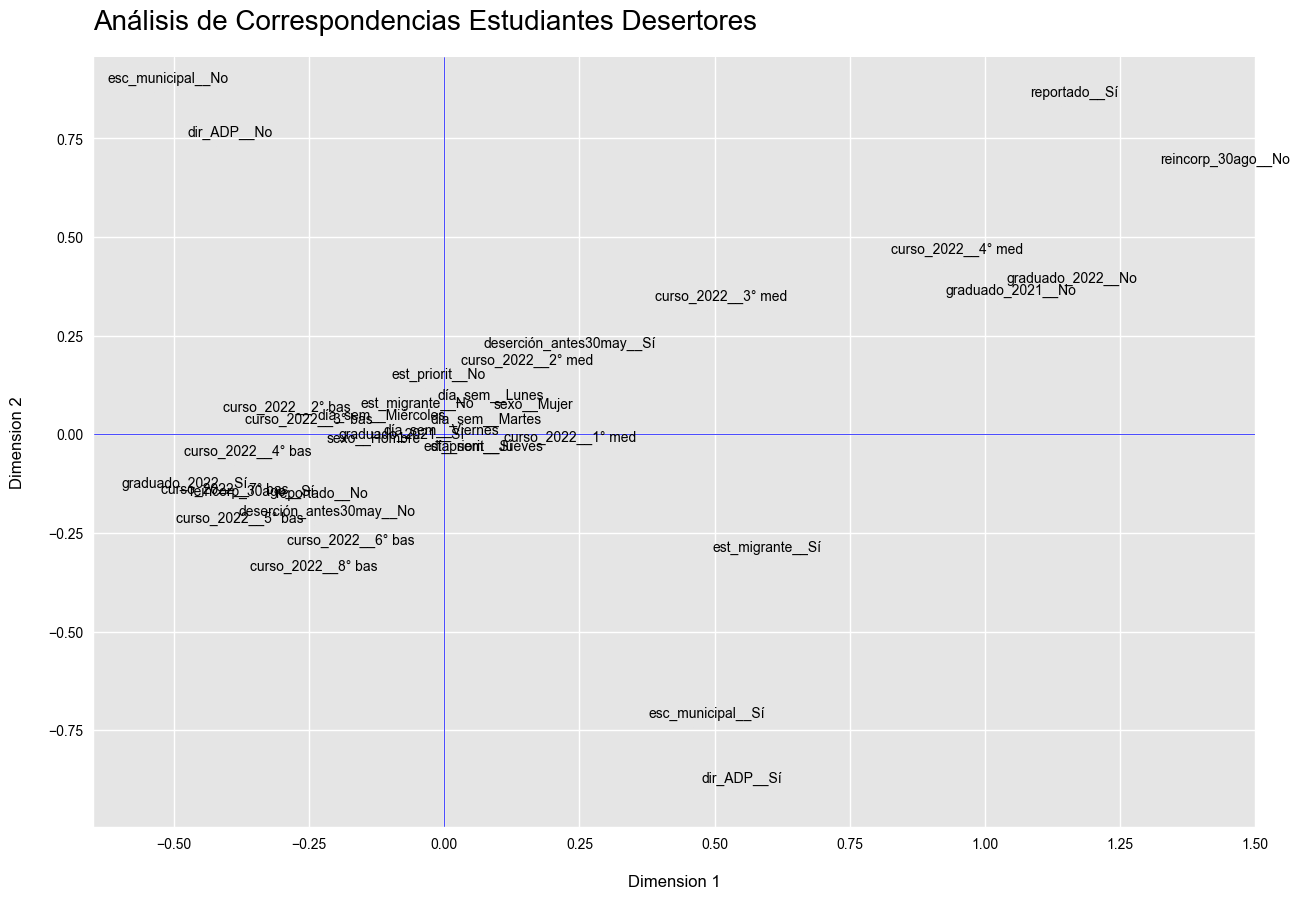

In [ ]:
# Graficación de las coordenadas de las columnas para visualizar agrupación de las etiquetas de las variables categoricas

fig, ax = plt.subplots(figsize=(15, 10))

ax.scatter(col_coords[0], col_coords[1], color='red', label='Attributes', s=0.00001)
for i, txt in enumerate(col_coords.index):
    ax.annotate(txt, (col_coords[0][i], 
                      col_coords[1][i]), 
                      color='black', 
                      fontsize=10, 
                      ha='center', 
                      va='center',
                      textcoords='offset points',
                      #arrowprops=dict(arrowstyle="->", color="gray", lw=0.5),
                      xytext=(10,10))#, rotation=0, xytext=(0, 0), textcoords='offset points')

ax.set_title('Análisis de Correspondencias Estudiantes Desertores', fontsize=20, loc='left',pad=20, color='black')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
#ax.legend(loc='upper left', fontsize=10, title='Variables', title_fontsize='13',  shadow=True, fancybox=True)

plt.axvline(0, color='blue', linestyle='-', lw=0.5)
plt.axhline(0, color='blue', linestyle='-', lw=0.5)
plt.xlim(-0.65, 1.5)
plt.xticks(color='black', fontsize=10)
plt.xlabel('\nDimension 1', fontsize=12, color='black')
plt.ylabel('Dimension 2\n', fontsize=12, color='black')
plt.yticks(color='black', fontsize=10)
sns.despine()
plt.show()

### Análisis:  

El mapa perceptual que arroja el Análisis de Correspondencias permite ver una agrupación de categorías en el extremo superior de las dos dimensiones en que se ha reducido la data categórica. Se observa proximidad entre las categorías de Reportados, No reincorporados, No graduados tanto en el 2021 como en el 2022, Cursos de enseñanza media (4to medio y 3ro medio) y Deserción antes del 30 de Mayo. Este análisis muestra niveles de coincidencias con lo arrojado con la caracterización de los clusters extraídos anteriormente. Del mapa se concluye que quienes son reportado y que no re-incorporan a la escuela son estudiantes del ciclo final de enseñanza media que no se graduan desus respectivos cursos y que abandonan las aulas antes del 30 de mayo como tendencia general.

### Entrenamiento algoritmo de boosting (Catboost)

In [796]:
# Importamos dataset para entrenar algoritmo

dfb = pd.read_csv('casestudy_dropout_clean.csv')
dfb.drop(columns=['DroppedOutMay30Before','nivel_enseñanza'], inplace=True)
dfb.head()  

,DayOfWeekDroppedOut,PrioritaryStudentIn2021,Female,Age,GraduatedIn2021,Migrant,ListedInDropoutReport,SchoolPrincipalADP,EnrolledByAug312022,MunicipalSchool,niv_rend,nivel_enseñanza2,periodo_abandono,anticipacion_abandono,asistencia_2021
0,5,0,0,18,0,0,0,1,0,1,Menor 4.0,4. 3ro-4to medio,Después_31_mayo,75,Menos del 85%
1,5,0,1,15,0,0,1,1,1,1,Menor 4.0,3. 1ro-2do medio,Antes_31_mayo,110,Menos del 85%
2,3,1,1,14,1,0,0,1,0,1,4.0 - 4.9,3. 1ro-2do medio,Antes_31_mayo,133,85% y más
3,1,1,1,14,1,0,1,1,0,1,5.0 - 5.9,3. 1ro-2do medio,Antes_31_mayo,121,85% y más
4,3,0,1,17,1,0,0,1,0,1,4.0 - 4.9,4. 3ro-4to medio,Después_31_mayo,77,85% y más


In [797]:
# Con pandas.category se convierten las variables categóricas en tipo category

dfb['nivel_enseñanza2'] = dfb['nivel_enseñanza2'].astype('category')
dfb['niv_rend'] = dfb['niv_rend'].astype('category')
dfb['periodo_abandono'] = dfb['periodo_abandono'].astype('category')
dfb['asistencia_2021'] = dfb['asistencia_2021'].astype('category')
dfb['DayOfWeekDroppedOut'] = dfb['DayOfWeekDroppedOut'].astype('category')


In [798]:
dfb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8516 entries, 0 to 8515
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   DayOfWeekDroppedOut      8516 non-null   category
 1   PrioritaryStudentIn2021  8516 non-null   int64   
 2   Female                   8516 non-null   int64   
 3   Age                      8516 non-null   int64   
 4   GraduatedIn2021          8516 non-null   int64   
 5   Migrant                  8516 non-null   int64   
 6   ListedInDropoutReport    8516 non-null   int64   
 7   SchoolPrincipalADP       8516 non-null   int64   
 8   EnrolledByAug312022      8516 non-null   int64   
 9   MunicipalSchool          8516 non-null   int64   
 10  niv_rend                 8516 non-null   category
 11  nivel_enseñanza2         8516 non-null   category
 12  periodo_abandono         8516 non-null   category
 13  anticipacion_abandono    8516 non-null   int64   
 14  asistenc

In [799]:
# Agregamos los clusters obtenidos con Kmeans al dataset y se convierten en variables categóricas

dfb['cluster_kmeans'] = kmeans.labels_
dfb['cluster_kmeans'] = dfb['cluster_kmeans'].astype('category')

dfb.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8516 entries, 0 to 8515
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   DayOfWeekDroppedOut      8516 non-null   category
 1   PrioritaryStudentIn2021  8516 non-null   int64   
 2   Female                   8516 non-null   int64   
 3   Age                      8516 non-null   int64   
 4   GraduatedIn2021          8516 non-null   int64   
 5   Migrant                  8516 non-null   int64   
 6   ListedInDropoutReport    8516 non-null   int64   
 7   SchoolPrincipalADP       8516 non-null   int64   
 8   EnrolledByAug312022      8516 non-null   int64   
 9   MunicipalSchool          8516 non-null   int64   
 10  niv_rend                 8516 non-null   category
 11  nivel_enseñanza2         8516 non-null   category
 12  periodo_abandono         8516 non-null   category
 13  anticipacion_abandono    8516 non-null   int64   
 14  asistenc

In [800]:
# Se separa el vector objetivo del dataset

y = dfb['EnrolledByAug312022']
X = dfb.drop(columns=['EnrolledByAug312022'])

In [801]:
# Se separa la data en train y test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20, stratify=y)

In [ ]:
# Se entrena un modelo de boostin con CatBoost

from catboost import CatBoostClassifier

categoricas = ['DayOfWeekDroppedOut','nivel_enseñanza2','niv_rend','periodo_abandono','asistencia_2021','cluster_kmeans']

cat = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=0, random_state=20, cat_features=categoricas)
cat.fit(X_train, y_train)

# realizamos predicciones
y_pred = cat.predict(X_test)

In [ ]:
# evaluamos el modelo Clasiicación

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.64      0.45      0.53       542
           1       0.86      0.93      0.90      2013

    accuracy                           0.83      2555
   macro avg       0.75      0.69      0.71      2555
weighted avg       0.82      0.83      0.82      2555



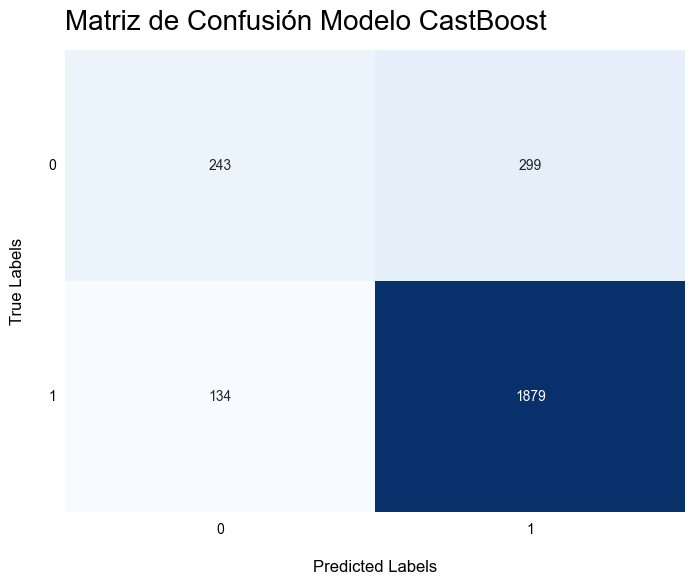

In [ ]:
# Graficar la matriz de confusión de prueba

cm_test = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('\nPredicted Labels', color='black')
plt.xticks(color='black')
plt.yticks(color='black', rotation=0)
plt.ylabel('True Labels\n', color='black')
plt.title('Matriz de Confusión Modelo CastBoost', color='black', fontsize=20, pad=15, loc='left')
plt.show()

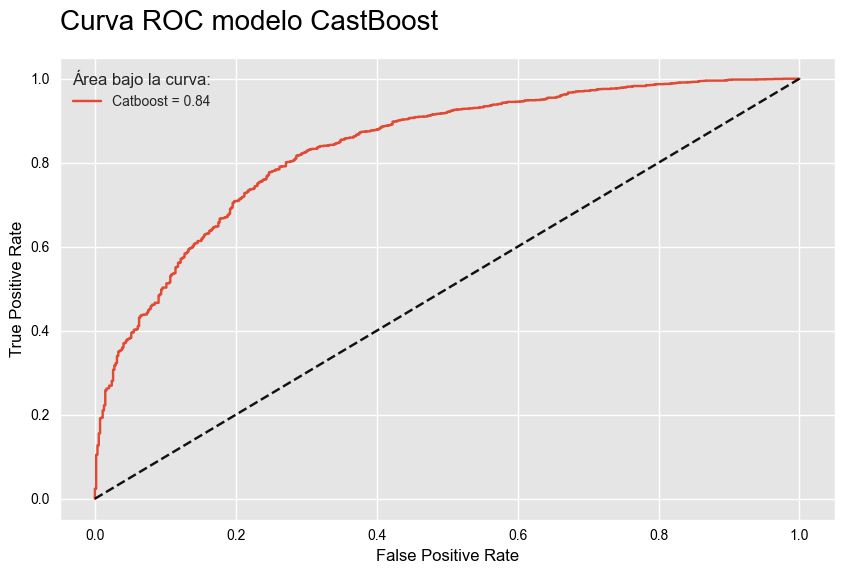

In [ ]:
# Graficar la curva ROC
from sklearn.metrics import roc_curve, roc_auc_score


# Predict probabilities or decision function
y_pred_proba = cat.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Catboost = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel('False Positive Rate', fontsize=12, color='black')
plt.ylabel('True Positive Rate', fontsize=12, color='black')
plt.title('Curva ROC modelo CastBoost', fontsize=20, color='black', loc='left', pad=20)
plt.xticks(color='black', fontsize=10)
plt.yticks(color='black', fontsize=10)
plt.legend(loc='upper left', fontsize=10, title='Área bajo la curva:', title_fontsize='12')
plt.show()

Average Precision Score: 0.94


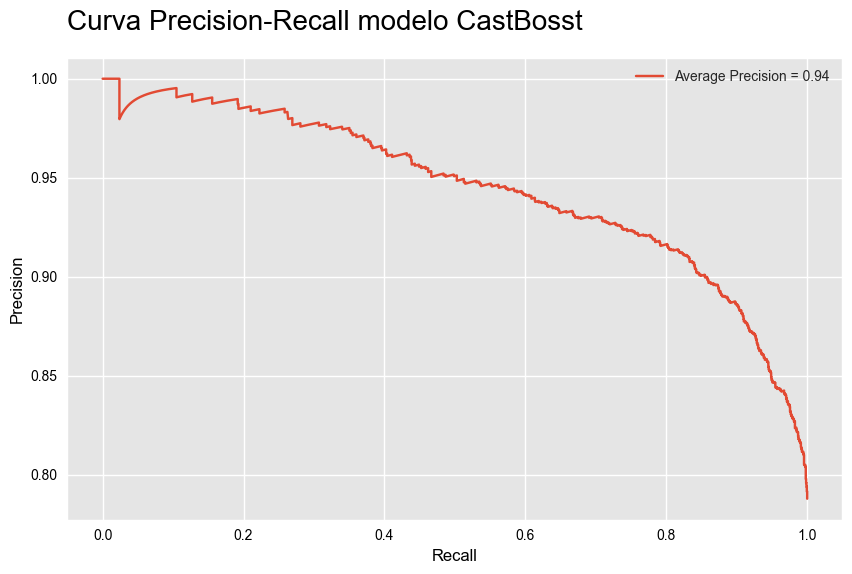

In [822]:
# calcular average precision score y graficar la curva precision-recall

from sklearn.metrics import average_precision_score, precision_recall_curve

# Calculate average precision score
average_precision = average_precision_score(y_test, y_pred_proba)
print(f'Average Precision Score: {average_precision:.2f}')

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

# Plot precision-recall curve

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'Average Precision = {average_precision:.2f}')
plt.xlabel('Recall', fontsize=12, color='black')
plt.ylabel('Precision', fontsize=12, color='black')
plt.title('Curva Precision-Recall modelo CastBosst', fontsize=20, color='black', loc='left', pad=20)
plt.xticks(color='black', fontsize=10)
plt.yticks(color='black', fontsize=10)
plt.legend(loc='upper right')
plt.show();


